# Train and Evaluation Notebook

In [ ]:
# packages to install
!pip install pandas
!pip install numpy
!pip install matplotlib
!pip install opencv-python
!pip install PyYAML
!pip install tqdm
!pip install requests
!pip install scipy
!pip install seaborn
!pip install os-sys
# installs pytorch (might need to change to a version that works on your computer)
!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

### These are the base YOLO weights for fine tuning on our dataset (download and move them to the base code folder)

https://drive.google.com/drive/folders/1VrggZSB75hKWMz9bER5zxjaTaaBJBaYJ?usp=sharing

### These are our final weights and training results, if you just want to evaluate the model (save them to ./runs/ and only run the evaluation cells)

https://drive.google.com/drive/folders/1iCj5N4QDv8vjkzt4EsSuRSGnluLMGDhQ?usp=sharing

### Download the dataset here:

https://zenodo.org/records/17272200

# IMPORTANT: you must change the file locations to match the location of the dataset, in all config .yaml files.

config files can be found in ./ultralytics/cfg/datasets

Files to change start with CUSTOM_

### Train and Eval Base Keypoint Model (only evaluates bounding box metrics)
use last cell in notebook to evaluate keypoint and other metrics

## Important: change the bracketed [] info with your directory. then run this cell to initalise file locations

In [ ]:
# remember to change "\"" to "/" in the file directories
code_directory = r"[FILE DIRECTORY FOR CODE]" # EG. C:/Downloads/Bone-Loss-Keypoint-Detection-Code
dataset_directory = r"[FILE DIRECTORY FOR DATASET]" # EG. C:/Downloads/perio_KPT

In [ ]:
!python Train_Model.py \
    --code-directory "{code_directory}" \
    --folds "5" \
    --epochs "200" \
    --image-size "640" \
    --output-csv "training_results_temp.csv"


### Evaluates the keypoint model (only Bounding Box Metrics)
use last cell in notebook to evaluate keypoint and other metrics

In [ ]:
from ultralytics import YOLO
# from sklearn.model_selection import KFold
import numpy as np
import os

# Define your custom dataset path
cfg_path = os.path.join(code_directory, 'ultralytics/cfg/datasets')

# weight paths
weight_path = os.path.join(code_directory, 'runs/pose')

# WARNING: change the below file locations if your trained weights are in different locations or have different names.
weight_files = ['train/weights/best.pt', 'train3/weights/best.pt', 'train4/weights/best.pt', 'train5/weights/best.pt', 'train6/weights/best.pt']


# Number of folds for cross-validation, change to 1 if you only want to train and evaluate one model
n_splits = 5


# make True to evaluate the test set only
test_set = False


# Placeholder for metrics
box_prec, box_recall, box_ap50, box_ap, pose_prec, pose_recall, pose_ap50, pose_ap = [], [], [], [], [], [], [], []

# Perform K-Fold Cross Validation
for fold in range(n_splits):
    print(f"Fold {fold}/{n_splits-1}")

    weights = os.path.join(weight_path, weight_files[fold])

    # Load the YOLOv8 model
    model = YOLO(weights)

    # gets the file location 
    if test_set:
        cur_file_loc = os.path.join(cfg_path, 'CUSTOM_pose_f'+str(fold)+'_test.yaml')
    else:
        cur_file_loc = os.path.join(cfg_path, 'CUSTOM_pose_f'+str(fold)+'.yaml')
    
    # Validate the model
    results = model.val(data=cur_file_loc, save=False)
    
    # Collect metrics
    box_prec.append(results.box.p)
    box_recall.append(results.box.r)
    box_ap50.append(results.box.ap50)
    box_ap.append(results.box.ap)
    pose_prec.append(results.pose.p)
    pose_recall.append(results.pose.r)
    pose_ap50.append(results.pose.ap50)
    pose_ap.append(results.pose.ap)
    
    # Display metrics for the current fold
    print('\n Box Metrics')
    print('precision: ', results.box.p)
    print('recall: ', results.box.r)
    print('AP50: ', results.box.ap50)
    print('AP50-95: ', results.box.ap)


print('#################### FINAL RESULTS ####################')

print('Box Metrics')
print('AVERAGE')
print('AP50: ', np.mean(box_ap50), ' (±', np.std(box_ap50), ')')
print('AP50-95: ', np.mean(box_ap),' (±', np.std(box_ap), ')')
print('precision: ', np.mean(box_prec), ' (±', np.std(box_prec), ')')
print('recall: ', np.mean(box_recall), ' (±', np.std(box_recall), ')')

# Reformat the list to combine each class for all folds
box_prec_combined = np.vstack(box_prec)
box_recall_combined = np.vstack(box_recall)
box_ap50_combined = np.vstack(box_ap50)
box_ap_combined = np.vstack(box_ap)

# Calculate and print the average metric for each class using each value in all folds
for i in range(box_prec_combined.shape[1]):
    print(f'Class {i}')
    print('AP50: ', np.mean(box_ap50_combined[:, i]), ' (±', np.std(box_ap50_combined[:, i]), ')')
    print('AP50-95: ', np.mean(box_ap_combined[:, i]), ' (±', np.std(box_ap_combined[:, i]), ')')
    print('precision: ', np.mean(box_prec_combined[:, i]), ' (±', np.std(box_prec_combined[:, i]), ')')
    print('recall: ', np.mean(box_recall_combined[:, i]), ' (±', np.std(box_recall_combined[:, i]), ')')


### Train Segmentation Model (dont need to run if you have existing weights)

In [ ]:
from ultralytics import YOLO
# from sklearn.model_selection import KFold
import numpy as np
import os

# Define your custom dataset path
cfg_path = os.path.join(code_directory, 'ultralytics/cfg/datasets/CUSTOM_seg.yaml')


# Load the YOLOv8 model
model = YOLO('yolov8n-seg.pt') 


# Train the model
model.train(data=cfg_path, epochs=20, imgsz=640)

    
# Validate the model
# results = model.val()



### Eval Segmentation Model

In [ ]:
import os
import cv2
import numpy as np
from ultralytics import YOLO
from shapely.geometry import Polygon
from shapely.ops import unary_union


# Directory containing images to predict
chosen_dir = os.path.join(dataset_directory, "0_Baseline/images")

# Output directory for predictions
base_output_dir = os.path.join(code_directory, "runs/segment/predict")



seg_weights = os.path.join(code_directory, "runs/segment/train/weights/best.pt")


# Load the YOLOv8 segmentation model
seg_model = YOLO(seg_weights)

output_dir = base_output_dir
suffix = 1
while os.path.exists(output_dir):
    output_dir = f"{base_output_dir}_{suffix}"
    suffix += 1
os.makedirs(output_dir, exist_ok=True)

# Get list of image files in chosen_dir
image_files = [
    os.path.join(chosen_dir, f)
    for f in os.listdir(chosen_dir)
    if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tif', '.tiff'))
]

# Predict on the list of image files directly
seg_model.predict(
    source=image_files,
    save=True,
    project=output_dir,
    imgsz=640,
    conf=0.5,
    iou=1.0
)

print(f"Predictions completed and saved to {output_dir}.")




def non_maximum_merge(masks, iou_threshold=0.5):
    """Merge overlapping masks based on IoU using shapely polygons."""
    merged = []
    used = [False] * len(masks)

    for i, m1 in enumerate(masks):
        if used[i]:
            continue
        poly1 = Polygon(m1)
        merged_poly = poly1
        used[i] = True

        for j in range(i+1, len(masks)):
            if used[j]:
                continue
            poly2 = Polygon(masks[j])
            if poly1.intersects(poly2):
                iou = poly1.intersection(poly2).area / poly1.union(poly2).area
                if iou > iou_threshold:
                    merged_poly = unary_union([merged_poly, poly2])
                    used[j] = True
        merged.append(np.array(merged_poly.exterior.coords, dtype=np.int32))
    return merged

# Process results
for i, result in enumerate(results):
    img_path = image_files[i]
    img = cv2.imread(img_path)
    masks = []

    for seg in result.masks.data:
        mask = seg.cpu().numpy().astype(np.uint8)
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        for cnt in contours:
            if len(cnt) >= 3:
                masks.append(cnt.squeeze())

    merged_masks = non_maximum_merge(masks)

    for merged in merged_masks:
        cv2.polylines(img, [merged], isClosed=True, color=(0, 255, 0), thickness=2)

    out_path = os.path.join(output_dir, os.path.basename(img_path))
    cv2.imwrite(out_path, img)





0: 640x640 47 Tooths, 90.2ms
1: 640x640 47 Tooths, 90.2ms
2: 640x640 28 Tooths, 90.2ms
3: 640x640 41 Tooths, 90.2ms
4: 640x640 54 Tooths, 90.2ms
5: 640x640 52 Tooths, 90.2ms
6: 640x640 30 Tooths, 90.2ms
7: 640x640 48 Tooths, 90.2ms
8: 640x640 30 Tooths, 90.2ms
9: 640x640 43 Tooths, 90.2ms
10: 640x640 39 Tooths, 90.2ms
11: 640x640 42 Tooths, 90.2ms
12: 640x640 29 Tooths, 90.2ms
13: 640x640 16 Tooths, 90.2ms
14: 640x640 50 Tooths, 90.2ms
15: 640x640 38 Tooths, 90.2ms
16: 640x640 50 Tooths, 90.2ms
17: 640x640 43 Tooths, 90.2ms
18: 640x640 43 Tooths, 90.2ms
19: 640x640 56 Tooths, 90.2ms
20: 640x640 56 Tooths, 90.2ms
21: 640x640 39 Tooths, 90.2ms
22: 640x640 38 Tooths, 90.2ms
23: 640x640 29 Tooths, 90.2ms
24: 640x640 45 Tooths, 90.2ms
25: 640x640 55 Tooths, 90.2ms
26: 640x640 39 Tooths, 90.2ms
27: 640x640 45 Tooths, 90.2ms
28: 640x640 45 Tooths, 90.2ms
29: 640x640 21 Tooths, 90.2ms
30: 640x640 57 Tooths, 90.2ms
31: 640x640 23 Tooths, 90.2ms
32: 640x640 34 Tooths, 90.2ms
33: 640x640 38 Toot

TypeError: 'SegmentMetrics' object is not iterable

### Keypoint, PBL and Furcation Involvement evaluation metrics
#### options for number of folds, test or val sets, with or without post-processing

Post-processing segments the teeth in the image, finds the edge pixels, matches predicted keypoints to each image, and snaps predicted keypoints to the edge of the tooth.

Adjust parameters based on the type of test you want to evaluate on

In [ ]:
from Tools.Eval import Evaluate_Model
import os


# Set parameters as variables (replace bracketed values with actual paths)
code_directory2 = code_directory
dataset_dir_standard = os.path.join(dataset_directory, '1_Experiment/standard_box') # Validation: "1_Experiment/standard_box",    Holdout Test: "1_Experiment/holdout_test_standard_box",             External Validation: "/3_External_Set/fixed_box",
dataset_dir_rotate = os.path.join(dataset_directory, '1_Experiment/rotating_box') # Validation: "1_Experiment/rotating_box",      Holdout Test: "1_Experiment/holdout_test_rotating_box/labels",      External Validation: "3_External_Set/rotating_box/labels",
fold_folder_nme = "fold"
save_loc = os.path.join(code_directory, 'runs/val_results') #                       Validation Path "runs/val_results"            Holdout Test Path: "runs/test_results",                              External Evaluation Path: "runs/external_eval_results",
test_set = False # Validation: False                              Holdout Test or External Validation: True
post_process_kpts = True # With post processing: "True"           Without post processing: "False"
image_size = 640
folds = 5
view_images = False # View images: True                Do not view images: False
include_fp_fn_nme = True
include_fp_fn_prck = True
non_max_merge_thresh = 0.1
pred_seg_iou = 0.70
pred_seg_conf = 0.15
pred_kpts_iou = 0.3
pred_kpts_conf = 0.48
furcation_dist_thresh = 0.05

# Create save location if it does not exist
if not os.path.exists(save_loc):
    os.makedirs(save_loc)
save_loc_temp = os.path.join(save_loc, 'run_1')
if os.path.exists(save_loc_temp):
    i = 1
    while os.path.exists(os.path.join(save_loc, f'run_{i}')):
        i += 1
    save_loc_temp = os.path.join(save_loc, f'run_{i}')
os.makedirs(save_loc_temp, exist_ok=True)
save_loc = save_loc_temp

# Paths (WARNING: THIS SPECIFIES TRAINED PATHS AUTO GENERATED BY TRAINING SCRIPT, CHANGE IF TARGET MODEL WEIGHTS ARE IN DIFFERENT SUBFOLDERS)
best_seg_weights = os.path.join(code_directory2, 'runs/segment/train/weights/best.pt')
weight_path_orig = os.path.join(code_directory2, 'runs/pose', fold_folder_nme)
weights_orig = [
    'train/weights/best.pt',
    'train3/weights/best.pt',
    'train4/weights/best.pt',
    'train5/weights/best.pt',
    'train6/weights/best.pt'
]
rotate_loc_orig = dataset_dir_rotate

if test_set:
    pred_imgs_orig = os.path.join(dataset_dir_standard, 'images')
    pred_lbls_orig = os.path.join(dataset_dir_standard, 'labels')
else:
    pred_imgs_orig = dataset_dir_standard
    pred_lbls_orig = dataset_dir_standard

# Keypoint classes
kpt_classes = [
    'CEJ_mesial', 'BoneLevel_mesial', 'RootLevel_mesial', 'CEJ_distal', 
    'BoneLevel_distal', 'RootLevel_distal', 'RootLevel_centre', 
    'FurcationApex', 'FurcationBoneLevel_mesial', 'FurcationBoneLevel_distal', 'ARR'
]

# Create a simple args object to mimic argparse.Namespace
class Args:
    pass

args = Args()
args.code_directory = code_directory
args.dataset_dir_standard = dataset_dir_standard
args.dataset_dir_rotate = dataset_dir_rotate
args.fold_folder_nme = fold_folder_nme
args.save_loc = save_loc
args.test_set = test_set
args.view_images = view_images
args.verbose_view_images = False
args.post_process_kpts = post_process_kpts
args.image_size = image_size
args.folds = folds
args.furcation_dist_thresh = furcation_dist_thresh
args.box_iou_thresh = 0.35
args.include_fp_fn_nme = include_fp_fn_nme
args.include_fp_fn_prck = include_fp_fn_prck
args.non_max_merge_thresh = non_max_merge_thresh
args.pred_seg_iou = pred_seg_iou
args.pred_seg_conf = pred_seg_conf
args.pred_kpts_iou = pred_kpts_iou
args.pred_kpts_conf = pred_kpts_conf

# Evaluate model
Evaluate_Model(
    weight_path_orig, weights_orig, rotate_loc_orig, pred_imgs_orig, pred_lbls_orig,
    best_seg_weights, kpt_classes, args
)


### predict model coords without post processing


image 1/1 I:\Datasets\periapical_xray_external2_best\chosen\Test Dataset 21.jpg: 480x640 2 Single Roots, 3 Double Roots, 3 PLSs, 35.8ms
Speed: 4.6ms preprocess, 35.8ms inference, 222.3ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 I:\Datasets\periapical_xray_external2_best\chosen\Test Dataset 21.jpg: 480x640 4 Tooths, 17.4ms
Speed: 2.0ms preprocess, 17.4ms inference, 6.9ms postprocess per image at shape (1, 3, 480, 640)


C:\Users\Banksy\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Banksy\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\_core\_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


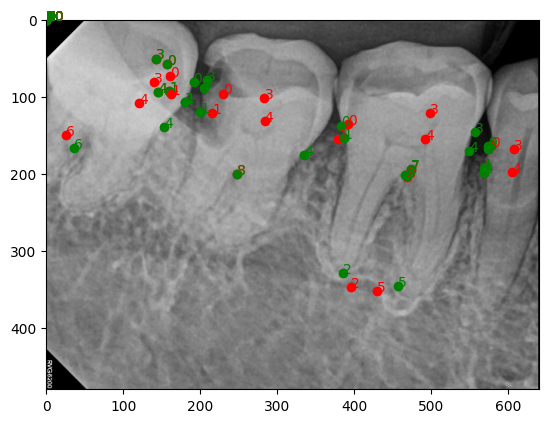


image 1/1 I:\Datasets\periapical_xray_external2_best\chosen\Test Dataset 23.jpg: 480x640 2 Single Roots, 2 Tripple Roots, 1 ARR, 10.0ms
Speed: 2.0ms preprocess, 10.0ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 I:\Datasets\periapical_xray_external2_best\chosen\Test Dataset 23.jpg: 480x640 9 Tooths, 9.3ms
Speed: 2.1ms preprocess, 9.3ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)


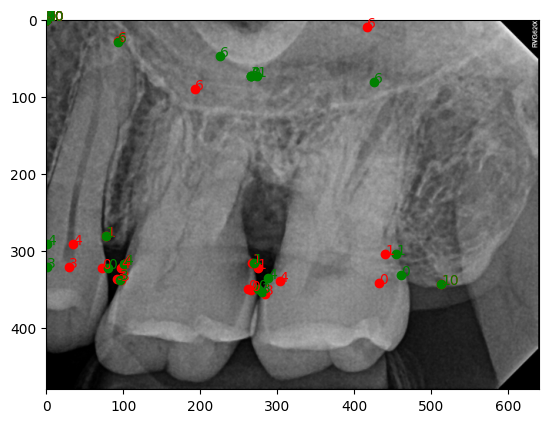


image 1/1 I:\Datasets\periapical_xray_external2_best\chosen\Test Dataset 24.jpg: 480x640 3 Double Roots, 1 ARR, 13.4ms
Speed: 2.0ms preprocess, 13.4ms inference, 3.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 I:\Datasets\periapical_xray_external2_best\chosen\Test Dataset 24.jpg: 480x640 5 Tooths, 9.3ms
Speed: 2.0ms preprocess, 9.3ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)


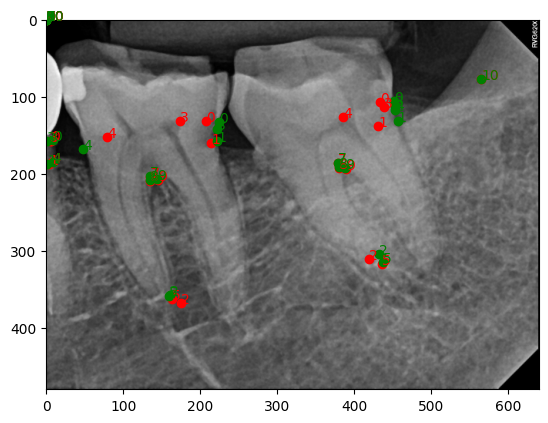


image 1/1 I:\Datasets\periapical_xray_external2_best\chosen\Test Dataset 28.jpg: 480x640 2 Single Roots, 2 Double Roots, 2 PLSs, 13.2ms
Speed: 2.0ms preprocess, 13.2ms inference, 4.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 I:\Datasets\periapical_xray_external2_best\chosen\Test Dataset 28.jpg: 480x640 7 Tooths, 9.1ms
Speed: 2.3ms preprocess, 9.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


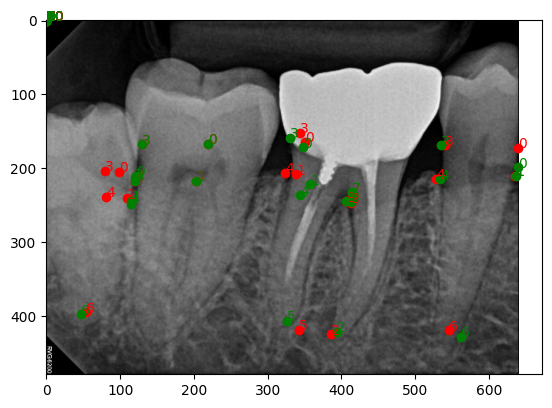


image 1/1 I:\Datasets\periapical_xray_external2_best\chosen\Test Dataset 32.jpg: 480x640 1 Single Root, 3 Double Roots, 12.2ms
Speed: 3.0ms preprocess, 12.2ms inference, 3.1ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 I:\Datasets\periapical_xray_external2_best\chosen\Test Dataset 32.jpg: 480x640 4 Tooths, 15.5ms
Speed: 2.1ms preprocess, 15.5ms inference, 3.0ms postprocess per image at shape (1, 3, 480, 640)


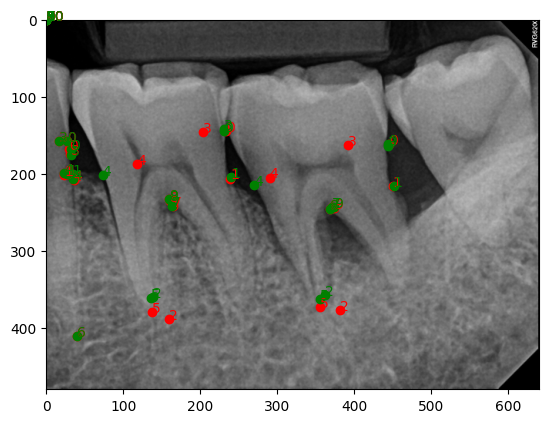


image 1/1 I:\Datasets\periapical_xray_external2_best\chosen\Test Dataset 33.jpg: 640x480 4 Single Roots, 1 PLS, 39.9ms
Speed: 3.0ms preprocess, 39.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 I:\Datasets\periapical_xray_external2_best\chosen\Test Dataset 33.jpg: 640x480 5 Tooths, 17.2ms
Speed: 2.1ms preprocess, 17.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 480)


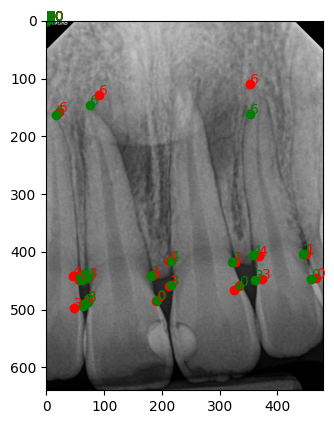


image 1/1 I:\Datasets\periapical_xray_external2_best\chosen\Test Dataset 37.jpg: 480x640 2 Double Roots, 1 ARR, 15.6ms
Speed: 3.0ms preprocess, 15.6ms inference, 3.1ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 I:\Datasets\periapical_xray_external2_best\chosen\Test Dataset 37.jpg: 480x640 6 Tooths, 16.8ms
Speed: 2.0ms preprocess, 16.8ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 640)


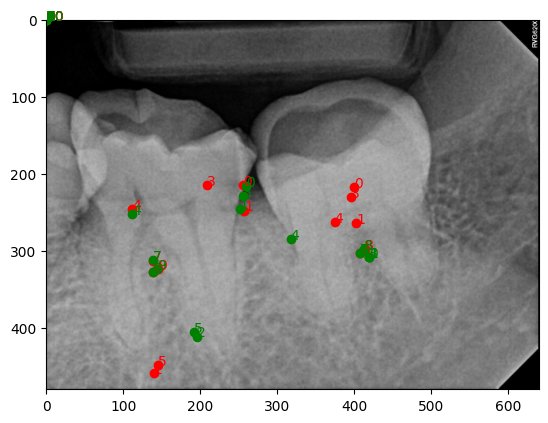


image 1/1 I:\Datasets\periapical_xray_external2_best\chosen\Test Dataset 38.jpg: 480x640 2 Double Roots, 13.3ms
Speed: 3.0ms preprocess, 13.3ms inference, 3.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 I:\Datasets\periapical_xray_external2_best\chosen\Test Dataset 38.jpg: 480x640 5 Tooths, 15.2ms
Speed: 3.1ms preprocess, 15.2ms inference, 3.0ms postprocess per image at shape (1, 3, 480, 640)


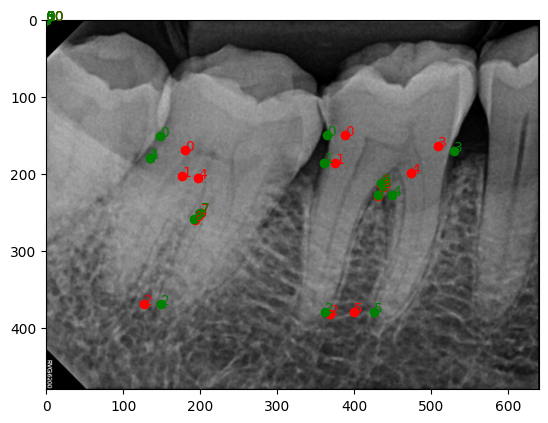


image 1/1 I:\Datasets\periapical_xray_external2_best\chosen\Test Dataset 39.jpg: 480x640 4 Single Roots, 1 Double Root, 1 Tripple Root, 1 ARR, 1 PLS, 14.2ms
Speed: 2.0ms preprocess, 14.2ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 I:\Datasets\periapical_xray_external2_best\chosen\Test Dataset 39.jpg: 480x640 5 Tooths, 16.5ms
Speed: 3.0ms preprocess, 16.5ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)


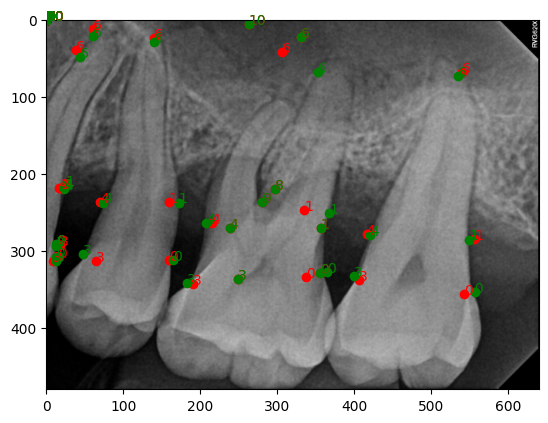


image 1/1 I:\Datasets\periapical_xray_external2_best\chosen\Test Dataset 40.jpg: 640x480 2 Single Roots, 1 ARR, 1 PLS, 34.8ms
Speed: 4.2ms preprocess, 34.8ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 I:\Datasets\periapical_xray_external2_best\chosen\Test Dataset 40.jpg: 640x480 2 Tooths, 41.0ms
Speed: 3.1ms preprocess, 41.0ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 480)


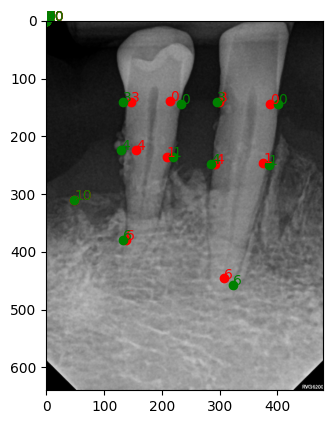


image 1/1 I:\Datasets\periapical_xray_external2_best\chosen\Test Dataset 41.jpg: 640x480 3 Single Roots, 23.7ms
Speed: 3.7ms preprocess, 23.7ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 I:\Datasets\periapical_xray_external2_best\chosen\Test Dataset 41.jpg: 640x480 5 Tooths, 29.3ms
Speed: 3.0ms preprocess, 29.3ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 480)


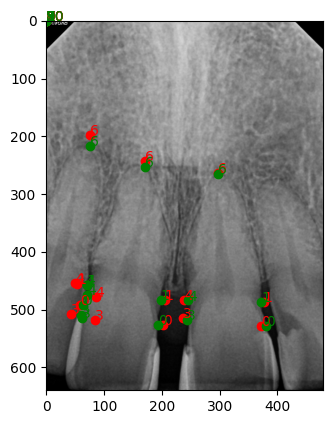


image 1/1 I:\Datasets\periapical_xray_external2_best\chosen\Test Dataset 43.jpg: 480x640 1 Single Root, 2 Double Roots, 1 PLS, 25.6ms
Speed: 3.0ms preprocess, 25.6ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 I:\Datasets\periapical_xray_external2_best\chosen\Test Dataset 43.jpg: 480x640 4 Tooths, 32.5ms
Speed: 3.1ms preprocess, 32.5ms inference, 4.0ms postprocess per image at shape (1, 3, 480, 640)


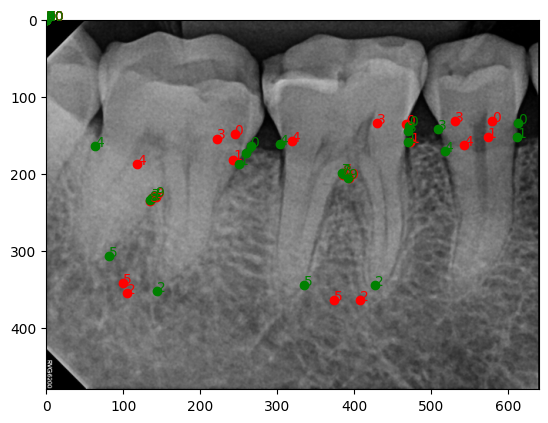


image 1/1 I:\Datasets\periapical_xray_external2_best\chosen\Test Dataset 44.jpg: 480x640 3 Single Roots, 1 Tripple Root, 23.6ms
Speed: 3.0ms preprocess, 23.6ms inference, 3.3ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 I:\Datasets\periapical_xray_external2_best\chosen\Test Dataset 44.jpg: 480x640 4 Tooths, 30.8ms
Speed: 3.1ms preprocess, 30.8ms inference, 3.0ms postprocess per image at shape (1, 3, 480, 640)


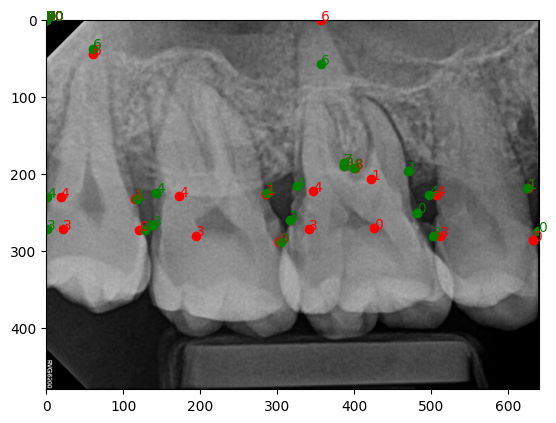


image 1/1 I:\Datasets\periapical_xray_external2_best\chosen\Test Dataset 49.jpg: 480x640 2 Single Roots, 1 ARR, 23.7ms
Speed: 3.0ms preprocess, 23.7ms inference, 3.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 I:\Datasets\periapical_xray_external2_best\chosen\Test Dataset 49.jpg: 480x640 2 Tooths, 29.9ms
Speed: 3.1ms preprocess, 29.9ms inference, 3.1ms postprocess per image at shape (1, 3, 480, 640)


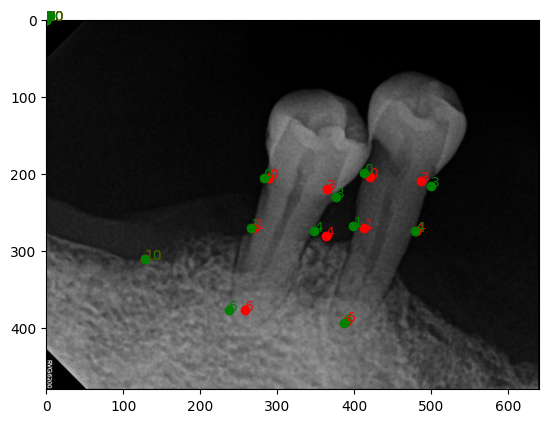


image 1/1 I:\Datasets\periapical_xray_external2_best\chosen\Test Dataset 9.jpg: 640x480 5 Single Roots, 4 PLSs, 24.5ms
Speed: 3.0ms preprocess, 24.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 I:\Datasets\periapical_xray_external2_best\chosen\Test Dataset 9.jpg: 640x480 6 Tooths, 31.7ms
Speed: 5.1ms preprocess, 31.7ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 480)


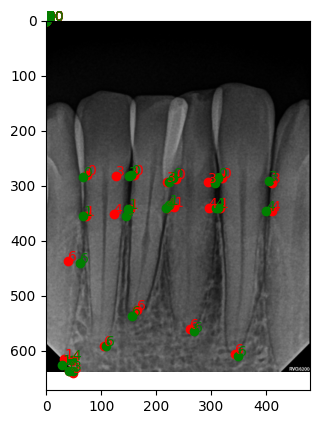

Inference completed and predictions saved.


: 

In [ ]:
from ultralytics import YOLO
import os
from Tools.Post_Processing import post_process

image_size = 640
post_process_kpts = True

# Use code_directory and dataset_directory variables
best_model_weights = os.path.join(code_directory, "runs/pose/train5/weights/best.pt")
best_seg_weights = os.path.join(code_directory, "runs/segment/train/weights/best.pt")

# Directory containing the images
image_directory = os.path.join(dataset_directory, "chosen")

# Directory to save predictions
output_directory = os.path.join(dataset_directory, "chosen_predictions")
os.makedirs(output_directory, exist_ok=True)

# Load YOLOv8 models
model = YOLO(best_model_weights)
model_seg = YOLO(best_seg_weights)

# Perform inference on all images in the specified directory
for image_file in os.listdir(image_directory):
    image_path = os.path.join(image_directory, image_file)
    results = model.predict(image_path, save=False, imgsz=image_size)
    if post_process_kpts:
        new_pred, old_kpts, _, img_width, img_height = post_process(
            model_seg, results, image_path, image_size, show_images=True
        )

print("Inference completed and predictions saved.")


# pred = model_kpts.predict(image_path, save=False, imgsz=image_size)

            # post processes the predicted keypoints
#             if post_process_kpts:
#                 new_pred, old_kpts, _ ,img_width, img_height= post_process(model_seg, pred, image_path, image_size)